# AdaptiveBinaryClusteringDelays


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# to install all dependencies use, uncomment the following line and restart the kernel
# %pip install -U -r requirements.txt

# Supervised learning of heterogeneous delays in a single layer of spiking neurons

**Abstract:** The response of a biological neuron depends on the precise timing of afferent spikes. This temporal aspect of the
neuronal code is essential in understanding information processing in neurobiology and applies particularly well to the
output of neuromorphic hardware such as event-based cameras. Though, most artificial neuronal models do not take
advantage of this minute temporal dimension and here, we
develop a model for the efficient detection of temporal spiking motifs based on a layer of neurons with heterogeneous
delays. Indeed, the variety of synaptic delays on the dendritic
tree allows to synchronize synaptic inputs as they reach the
basal dendritic tree. We show this can be formalized as time-invariant logistic regression which can trained using labelled
data. We apply this model for solving the specific problem
of detecting motion and demonstrate its use by applying it
on synthetic naturalistic videos transformed to event-based
streams similar to the output of a silicon retina. In particular, we show how its accuracy may evolve as a function of
the total computational load. This end-to-end event-based
computational brick could help improve the performance of
future Spiking Neural Network solutions currently used in
neuromorphic chips.

## Heterogeneous delays model

## Heterogeneous delays model

We design a model based on heterosynaptic delays. We will define in the assembly of neurons where each synapse
is defined by a weight *ws* at different delays *τs*. See the following figure: 

In [3]:
datetag = None

In [4]:
datetag = '2022-07-12'

In [5]:
figpath = None

In [6]:
import argparse

def init(datetag=datetag, args=[]) :

    parser = argparse.ArgumentParser()

    if datetag is None:
        from time import strftime, gmtime
        datetag = strftime("%Y-%m-%d", gmtime())

    parser.add_argument("--datetag", type=str, default=datetag, help="a tag to identify a simulation run")

    ## Polychronous Groups PG
    parser.add_argument("--N_pre", type=int, default=256, help="number of presynaptic inputs")
    parser.add_argument("--N_PG_time", type=int, default=75, help="number of timesteps in PG, must be a odd number for convolutions")
    parser.add_argument("--N_PGs", type=int, default=35, help="number of polychronous groups")
    parser.add_argument("--E_PG", type=float, default=10, help="excitability range of PGs")
    parser.add_argument("--p_PG", type=float, default=.001, help="ratio of non-zero coefficients in PGs")
    parser.add_argument("--tau_decay", type=float, default=2., help="time constant for synchrony")

    ## Raster plots
    parser.add_argument("--N_time", type=int, default=1000, help="number of timesteps for the raster plot")
    parser.add_argument("--N_trials", type=int, default=10, help="number of trials")
    parser.add_argument("--p_B", type=int, default=.001, help="prior probability of firing for postsynaptic raster plot")
    parser.add_argument("--p_A", type=int, default=.01, help="prior probability of firing for presynaptic raster plot")
    parser.add_argument("--seed", type=int, default=42, help="seed")

    ## figures
    parser.add_argument("--verbose", type=bool, default=False, help="Displays more verbose output.")
    parser.add_argument("--fig_width", type=float, default=12, help="width of figure")
    parser.add_argument("--phi", type=float, default=1.61803, help="beauty is gold")
    parser.add_argument("--N_PG_show", type=float, default=5, help="number of PG to show in plot_PG")

    return parser.parse_args(args = args)

In [7]:
opt = init(datetag)


In [8]:
opt

Namespace(datetag='2022-07-12', N_pre=256, N_PG_time=75, N_PGs=35, E_PG=10, p_PG=0.001, tau_decay=2.0, N_time=1000, N_trials=10, p_B=0.001, p_A=0.01, seed=42, verbose=False, fig_width=12, phi=1.61803, N_PG_show=5)

### generative model for polychronous groups

In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch

class ABCD:

    def __init__(self, opt):
        self.opt = opt
        self.d = vars(opt)
        self.init()

    def init(self):
        decaying_impulse = torch.zeros(self.opt.N_PG_time)
        decaying_impulse[(self.opt.N_PG_time//2+1):] = torch.exp(-torch.linspace(0, self.opt.N_PG_time//2, self.opt.N_PG_time//2) / self.opt.tau_decay)
        decaying_impulse = decaying_impulse.flip([0])
        self.K_decay = torch.eye(self.opt.N_PGs).unsqueeze(2) * decaying_impulse.unsqueeze(0).unsqueeze(0)

    def set_PG(self, seed=None):
        if seed is None: seed = self.opt.seed
        torch.manual_seed(seed)
        # define PGs as matrices to be used as kernels
        PG = self.opt.E_PG * torch.randn(self.opt.N_pre, self.opt.N_PGs, self.opt.N_PG_time)
        #threshold = torch.abs(PG).quantile(1-self.opt.p_PG)
        # TODO : get analytically
        from scipy.stats import norm
        threshold = self.opt.E_PG * norm.ppf(1-self.opt.p_PG)
        PG *= (torch.abs(PG) > threshold)
        PG =  torch.conv1d(PG, self.K_decay, padding=self.opt.N_PG_time//2)
        return PG

    def smooth_PG(self, precision=1, seed=None):
        # TODO : use that function
        rates = torch.ones(self.opt.N_PGs,self.opt.N_pre,self.opt.N_PG_time)*self.opt.p_PG
        PG = torch.bernoulli(rates)

        x = torch.arange(-self.opt.N_PG_time//2,self.opt.N_PG_time//2)
        kernel = gaussian(x,0,1/precision)
        kernel /= kernel.sum()
        kernels = torch.ones(self.opt.N_pre, 1, self.opt.N_PG_time)*kernel

        PG_proba = torch.nn.functional.conv1d(PG,kernels, padding='same', groups=self.opt.N_pre)
        return PG_proba

    def get_b(self, seed=None):
        if seed is None: seed = self.opt.seed
        torch.manual_seed(seed)
        # draw causes (PGs)
        # as a matrix of sparse PG activations
        b_proba = torch.ones(self.opt.N_trials, self.opt.N_PGs, self.opt.N_time)*self.opt.p_B
        return torch.bernoulli(b_proba)

    def model_a(self, b, PG):
        # draws the probability of firing for each presynaptic address over time
        # input b -> postsynaptic raster plot
        #       PG -> polychronous groups spatio temporal kernels
        #       p_A -> prior proba of firing for the presynaptic addresses
        logit_p_A = torch.logit(torch.tensor(self.opt.p_A))
        return torch.sigmoid(logit_p_A + torch.conv1d(b*1., PG, padding=self.opt.N_PG_time//2))

    def draw_a(self, b, PG, seed=None):
        if seed is None: seed = self.opt.seed
        torch.manual_seed(seed)
        # generate the corresponding raster plot
        a_proba = self.model_a(b, PG)
        return torch.bernoulli(a_proba)

    def inference_with_PGs(self, a, b, PG):
        # infer 
        b_hat = torch.conv_transpose1d(a*1., PG, padding=self.opt.N_PG_time//2)
        # decision
        p_B = b.sum()/(self.opt.N_trials*self.opt.N_PGs*self.opt.N_time) # ça suppose qu'on connait b.sum()...
        b_threshold = torch.quantile(b_hat, 1-p_B)
        b_hat_bin = (b_hat>b_threshold)
        return b_hat, b_hat_bin

    def generative_model(self, seed=None):
        if seed is None: seed = self.opt.seed
        PG, b = self.set_PG(seed=seed), self.get_b(seed=seed+1)
        a = self.draw_a(b, PG, seed=seed+2)
        return a, b, PG


    def test_model(self, PG, PG_true=None, seed=None):
        if seed is None: seed = self.opt.seed
        torch.manual_seed(seed)
        if PG_true is None: PG_true = PG
        # define PGs
        # draw causes (PGs)
        b = self.get_b(seed=seed)
        # generate the corresponding raster plot
        a = self.draw_a(b, PG_true, seed=seed+1)
        # infer 
        b_hat, b_hat_bin = self.inference_with_PGs(a, b, PG)
        return torch.mean((b_hat_bin == b)*1.), torch.mean(b_hat_bin[b==1]*1.), 1-torch.mean(b_hat_bin[b==0]*1.)

    def plot_PG(self, PG, cmap='seismic', colors=None, aspect=None, figsize=None):

        if PG.dtype == torch.bool:
            PG_max = 1
            PG_min = 0
            cmap = 'binary'
        else:
            #PG = PG.numpy()
            PG_max = np.abs(PG).max().item()
            PG_min = -PG_max

        if figsize is None:
            figsize = (self.opt.fig_width, self.opt.fig_width/self.opt.phi)

        subplotpars = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.87)
        fig, axs = plt.subplots(1, self.opt.N_PG_show, figsize=figsize, subplotpars=subplotpars)
        for i_PG in range(self.opt.N_PG_show):
            ax = axs[i_PG]
            ax.set_axisbelow(True)

            for i in range(PG.shape[0]):
                ax.scatter(y=i*np.ones((self.opt.N_PG_time,)), 
                           x=np.arange(self.opt.N_PG_time), 
                           s=np.abs(PG[i, i_PG, :]), c='k', #PG[i, i_PG, :], 
                           alpha=.8, cmap=cmap)
            ax.set_xlim(0, PG.shape[2])
            #ax.imshow(PG[:, i_PG, :], cmap=cmap, vmin=PG_min, vmax=PG_max, interpolation='none')
            ax.set_xlabel('Delay')
            ax.set_title(f'PG #{i_PG+1}', color='k' if colors is None else colors[i_PG])
            if not aspect is None: ax.set_aspect(aspect)

            ax.set_ylim(-.5, self.opt.N_pre-.5)
            ax.set_yticks(np.arange(0, self.opt.N_pre, 1))
            ax.set_yticklabels(np.arange(0, self.opt.N_pre, 1)+1)
            if i_PG>0: ax.set_yticklabels([])

            for side in ['top', 'right']: ax.spines[side].set_visible(False)
            ax.set_xticks([0, self.opt.N_PG_time//2, self.opt.N_PG_time-1])
            ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(self.opt.N_PG_time//4))
            #ax.xaxis.set_minor_locator(AutoMinorLocator(4))
            #ax.set_xticklabels([-(self.opt.N_PG_time//2), 0, self.opt.N_PG_time//2])
            ax.set_xticklabels([0, (self.opt.N_PG_time//2), (self.opt.N_PG_time)])
            ax.grid(True, axis='y', linestyle='-', lw=1)
            ax.grid(True, axis='x', which='both', linestyle='-', lw=.1)

        axs[0].set_ylabel('Synapse')
        return fig, axs

    def plot_b(self, b, trial_nb = 0, cmap = 'binary'):
        fig, ax = plt.subplots(1, 1, figsize=(self.opt.fig_width, self.opt.fig_width/self.opt.phi))
        ax.imshow(b[trial_nb, ...].numpy(), cmap=cmap, interpolation='none')
        ax.set_ylabel('@post')
        ax.set_xlabel('time')

    def plot_a(self, a, trial_nb = 0, cmap = 'binary'):
        fig, ax = plt.subplots(2, 1, figsize=(self.opt.fig_width, self.opt.fig_width/self.opt.phi))
        ax[0].matshow(a[trial_nb, ...].numpy(), cmap=cmap, interpolation='none')
        ax[0].set_ylabel('Synapse')
        ax[0].set_xlabel('Time')
        ax[1].step(np.arange(self.opt.N_pre), a.numpy().mean(axis=(0, 2)), label='firing rate')
        ax[1].hlines(self.opt.p_A, 0, self.opt.N_pre, linestyles='--', color='orange', label='probability of firing for each address')
        ax[1].set_xlabel('address')
        ax[1].set_ylim(0)
        ax[1].legend();

    def plot_inference(self, b, b_hat, b_hat_bin, trial_nb = 0, t_min = 100, t_max = 150):
        fig, ax = plt.subplots(1, 3, figsize=(self.opt.fig_width, self.opt.fig_width))
        ax[2].imshow(b_hat_bin[trial_nb, :, t_min:t_max])
        ax[0].imshow(b[trial_nb, :, t_min:t_max])
        ax[1].imshow(b_hat[trial_nb, :, t_min:t_max])

    def plot_inference_histo(self, b_hat, nb_bins = 100):
        fig, ax = plt.subplots(1, 1, figsize=(self.opt.fig_width, self.opt.fig_width/self.opt.phi))
        ax.hist(b_hat.numpy().ravel(), bins=nb_bins)
        ax.set_ylabel('smarts')
        ax.set_xlabel('value of b_hat')
        ax.set_yscale('log')

In [10]:
def printfig(fig, name, ext='pdf', figpath=figpath):
    dpi_exp = None
    bbox = 'tight'
    fig.savefig(os.path.join(figpath, name + '.' + ext), dpi = dpi_exp, bbox_inches=bbox, transparent=True)

In [11]:
opt = init(datetag)
env = ABCD(opt)

In [12]:
opt

Namespace(datetag='2022-07-12', N_pre=256, N_PG_time=75, N_PGs=35, E_PG=10, p_PG=0.001, tau_decay=2.0, N_time=1000, N_trials=10, p_B=0.001, p_A=0.01, seed=42, verbose=False, fig_width=12, phi=1.61803, N_PG_show=5)

#### dev sandox

In [13]:
opt = init(datetag)
env = ABCD(opt)
a, b, PG = env.generative_model()

In [14]:
PG.shape

torch.Size([256, 35, 75])

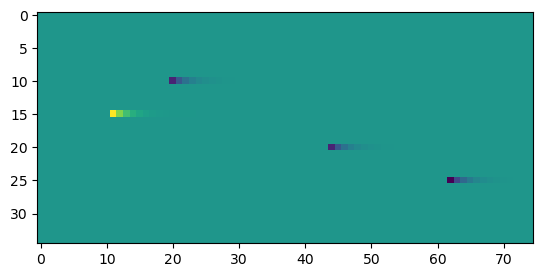

In [15]:
plt.imshow(PG[0, :, :])

In [16]:
decaying_impulse.flip?

Object `decaying_impulse.flip` not found.


torch.Size([75])

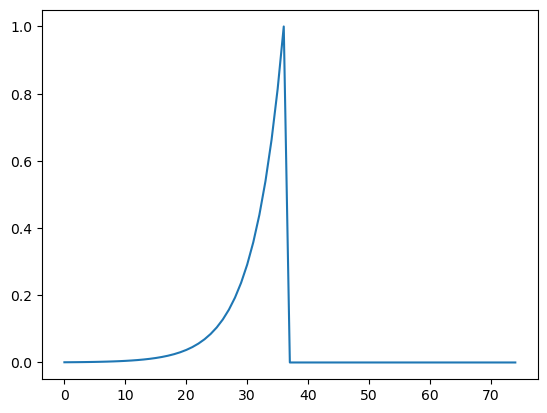

In [17]:
N_PGs, N_PG_time = PG.shape[1], PG.shape[2]
tau_decay = 5
decaying_impulse = torch.zeros(N_PG_time)
decaying_impulse[(N_PG_time//2+1):] = torch.exp(-torch.linspace(0, N_PG_time//2, N_PG_time//2) / tau_decay)
decaying_impulse = decaying_impulse.flip([0])
plt.plot(decaying_impulse)
decaying_impulse.shape

In [18]:
K_decay = torch.eye(N_PGs).unsqueeze(2) * decaying_impulse.unsqueeze(0).unsqueeze(0)
K_decay.shape

torch.Size([35, 35, 75])

In [19]:
a, b, PG = env.generative_model()
PG =  torch.conv1d(PG, K_decay, padding=N_PG_time//2)
PG.shape

torch.Size([256, 35, 75])

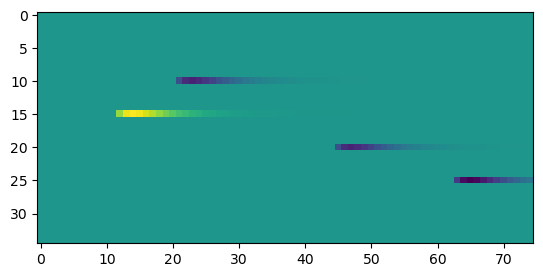

In [20]:
plt.imshow(PG[0, :, :])

# generative model for polychronous groups

/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_75096/4230626902.py:118: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(y=i*np.ones((self.opt.N_PG_time,)),


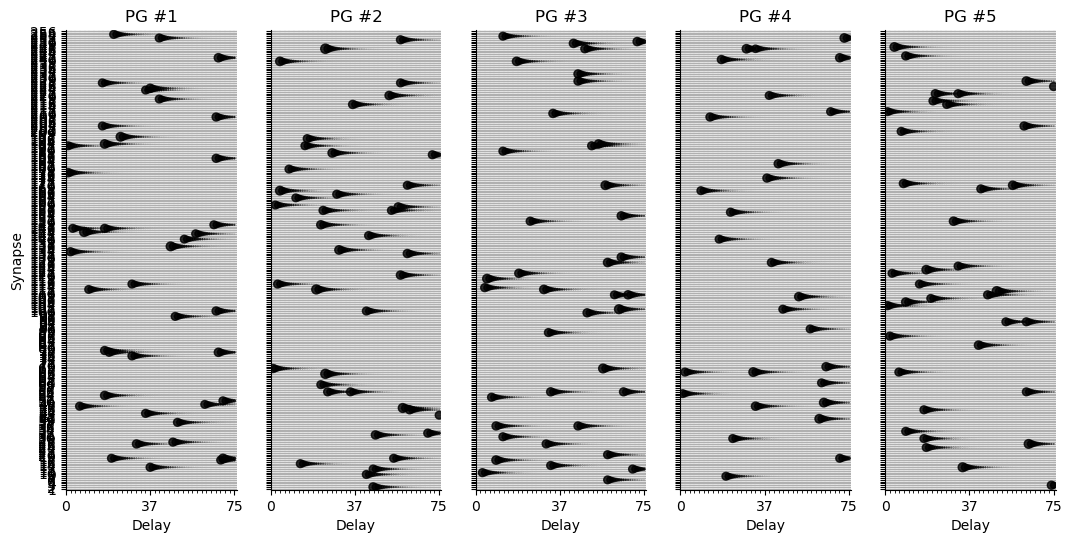

In [21]:
a, b, PG = env.generative_model()
env.plot_PG(PG);
# TODO find a better rule to generate PGs

Draw one instance of single PGs:

/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_75096/4230626902.py:118: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(y=i*np.ones((self.opt.N_PG_time,)),


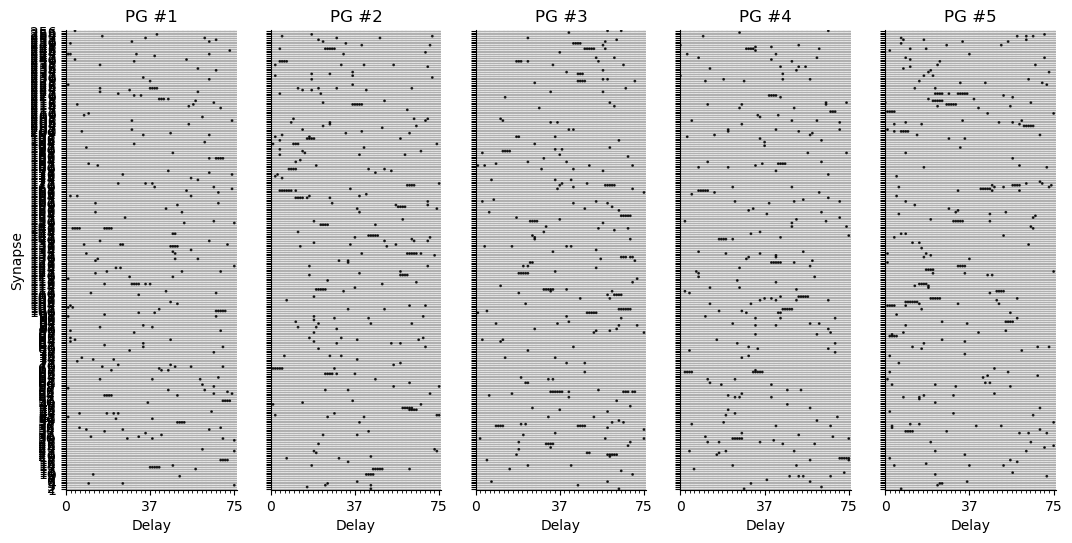

In [22]:
logit_p_A = torch.logit(torch.tensor(opt.p_A));
rp_PG = torch.sigmoid(logit_p_A + PG) > torch.rand(opt.N_pre, opt.N_PGs, opt.N_PG_time)
env.plot_PG(rp_PG);

Draw the occurrences of PGs:

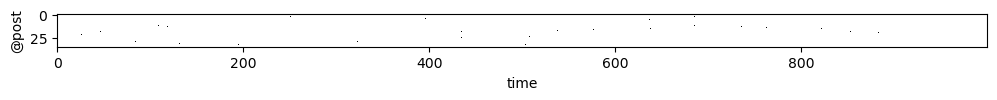

In [23]:
env.plot_b(b, trial_nb = 2)

Resulting raster plot:

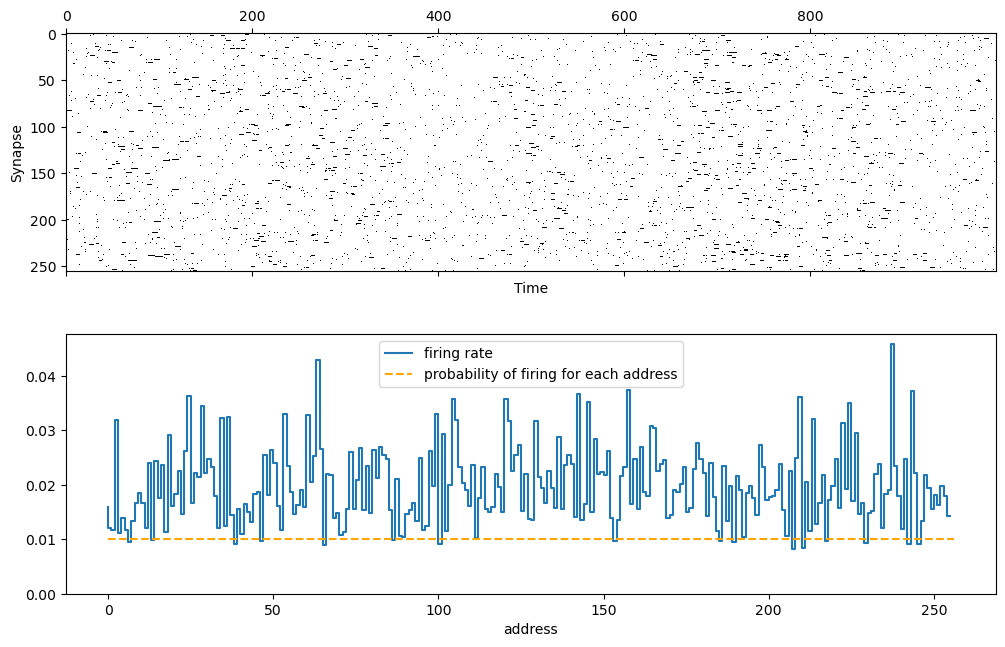

In [24]:
env.plot_a(a, trial_nb = 7)
# TODO correct this firing rate

# inference model for polychronous groups

knowing the raster plot `a`, let's try to infer `b` :

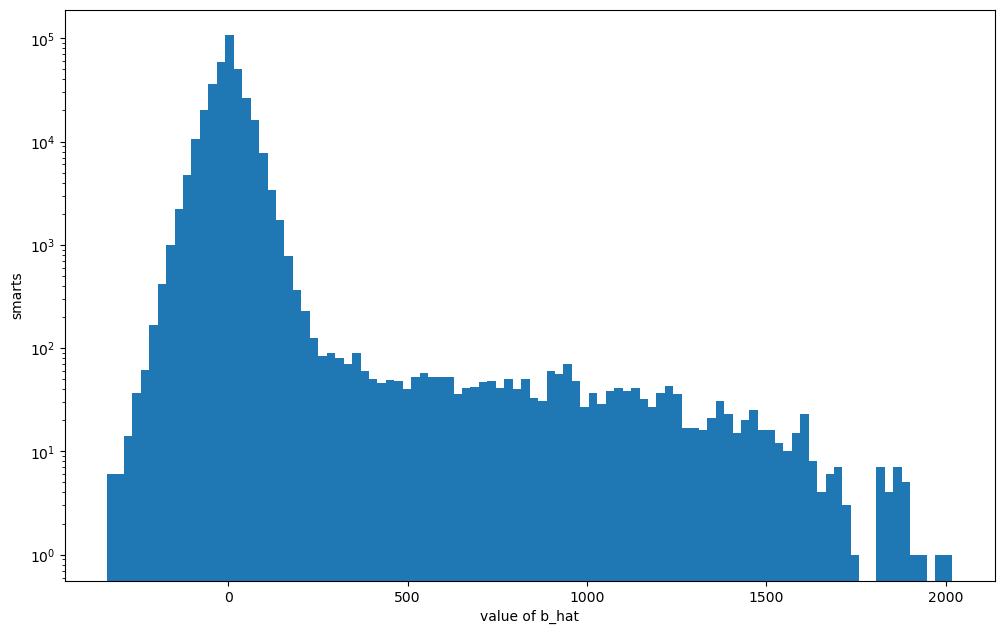

In [25]:
b_hat, b_hat_bin = env.inference_with_PGs(a, b, PG)
env.plot_inference_histo(b_hat)

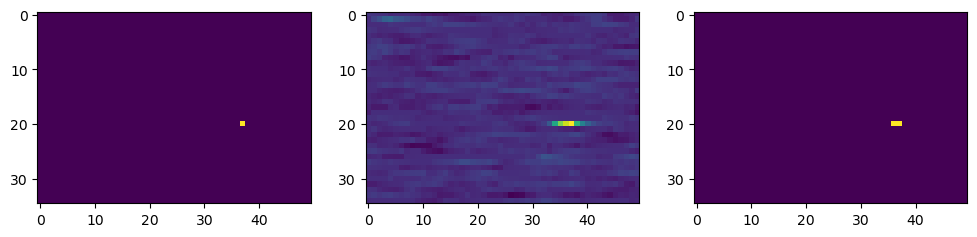

In [26]:
env.plot_inference(b, b_hat, b_hat_bin)

## test model, learning 

In [27]:
%%timeit
accuracy, TP, TN = env.test_model(PG, PG)

190 ms ± 4.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
accuracy, TP, TN = env.test_model(PG, PG)
print(f'accuracy={accuracy.item()*100:.2f}%, TP={TP.item()*100:.2f}%, TN={TN.item()*100:.2f}%')

accuracy=99.90%, TP=48.30%, TN=99.95%


## Figure 1

In [29]:
opt = init(datetag + '_fig1')
opt.N_pre = 10
opt.N_PG_time = 71
opt.p_PG = .07
opt.p_A = 0.0015
opt.p_B = 0.0015
opt.N_PGs = 4 
opt.N_PG_show = opt.N_PGs
opt.N_trials = 1
opt.N_time = 1000
opt.seed = 2373

opt.fig_width = 4.5
env_fig1 = ABCD(opt)
a, b, PG = env_fig1.generative_model()

In [30]:
opt

Namespace(datetag='2022-07-12_fig1', N_pre=10, N_PG_time=71, N_PGs=4, E_PG=10, p_PG=0.07, tau_decay=2.0, N_time=1000, N_trials=1, p_B=0.0015, p_A=0.0015, seed=2373, verbose=False, fig_width=4.5, phi=1.61803, N_PG_show=4)

In [31]:
figsize = (env_fig1.opt.fig_width, env_fig1.opt.fig_width/2.5)
colors = ['r', 'g' , 'b' , 'm']
env_fig1 = ABCD(opt)
a, b, PG = env_fig1.generative_model()

In [32]:
#b[0, 3, 350] = True
#b[0, 2, 350] = True
#b[0, 1, 150] = True
b[0, 0, 50] = True
#b[0, 3, 180] = True
#b[0, 3, 42] = True
b[0, 1, 201] = True
b[0, 1, 114] = True
b[0, 2, 42] = True
b[0, 2, 104] = True
#b[0, 0, 50] = True
b.shape

torch.Size([1, 4, 1000])

/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_75096/4230626902.py:118: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(y=i*np.ones((self.opt.N_PG_time,)),


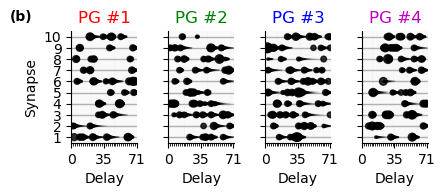

In [33]:
fig, axs = env_fig1.plot_PG(torch.relu(PG), cmap='Reds', aspect=12, colors=colors, figsize=figsize)
fig.text(0.03, 0.95,'(b)', horizontalalignment='center', verticalalignment='center', weight='bold')
if not figpath is  None: fig.savefig(figpath + '/figure_1b.pdf') # TODO use printfig
plt.show()

Then from the following raster plot, each PG described if the figure above will be selective to the spatio-temporal pattern of the same color: 

In [34]:
%pwd

'/Users/laurentperrinet/metagit/ABCD/2022-11-23_cosyne-THC/dev'

[Text(0, 0, '1'), Text(0, 1, '2'), Text(0, 2, '3'), Text(0, 3, '4')]

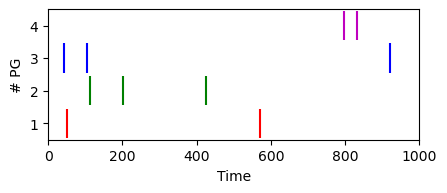

In [35]:
import matplotlib
#subplotpars = matplotlib.figure.SubplotParams(left=0., right=1., bottom=0., top=1., wspace=0., hspace=0.,)
subplotpars = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975)
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(env_fig1.opt.fig_width, env_fig1.opt.fig_width/2.5), subplotpars=subplotpars)
colors = ['r', 'g' , 'b' , 'm']
ax.eventplot([np.where(b[0, i, :] == 1.)[0] for i in range(0, env_fig1.opt.N_PGs)], 
              colors=colors, lineoffsets=1, linelengths=0.9);
ax.set_ylabel('# PG')
ax.set_xlabel('Time')
ax.set_xlim(0, env_fig1.opt.N_time)
ax.set_ylim(-.5, env_fig1.opt.N_PGs-.5)
ax.set_yticks(np.arange(0, env_fig1.opt.N_PGs))
ax.set_yticklabels(np.arange(0, env_fig1.opt.N_PGs)+1)
#if not figpath is  None: fig.savefig(figpath + '/figure_1b.pdf')

It results in the following activation of the postsynaptic neurons (activation probability with a Bernoullin trial):

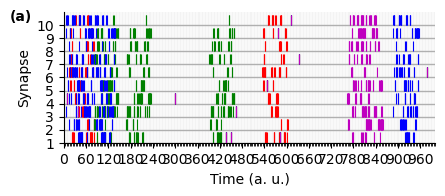

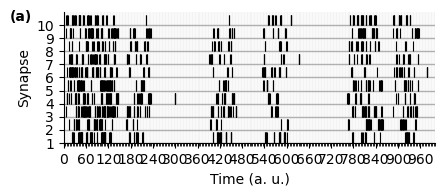

In [36]:
subplotpars = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975)
for suff in ['', '_k']:
    fig, ax = plt.subplots(1, 1, figsize=figsize, subplotpars=subplotpars)
    for i_PG in range(env_fig1.opt.N_PGs):
        b_ = torch.zeros_like(b)
        b_[0, i_PG, :] = b[0, i_PG, :]
        a_ = env_fig1.draw_a(b_, PG)
        #ax.eventplot([np.where(a_[0, i, :] == 1.)[0] for i in range(0, env_fig1.opt.N_pre)], 
        #              colors=colors[i_PG] if suff=='' else 'k', 
        #              lineoffsets=1, linelengths=0.9, linewidths=1);
        for i in range(0, env_fig1.opt.N_pre):
            ax.eventplot(np.where(a_[0, i, :] == 1.)[0], colors=colors[i_PG] if suff=='' else 'k', 
                         lineoffsets=1.*i+.4, linelengths=0.8, linewidths=0.8);

    # TODO : report these in the code above
    ax.set_ylabel('Synapse')
    ax.set_xlabel('Time (a. u.)')
    ax.set_xlim(0, env_fig1.opt.N_time)
    ax.set_ylim(0, env_fig1.opt.N_pre)
    ax.set_yticks(np.arange(0, env_fig1.opt.N_pre, 1))
    ax.set_yticklabels(np.arange(0, env_fig1.opt.N_pre, 1)+1)
    for side in ['top', 'right']: ax.spines[side].set_visible(False)
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(4))
    ax.set_xticks(np.arange(0, env_fig1.opt.N_time+1, 60))
    ax.set_xticklabels(np.arange(0, env_fig1.opt.N_time+1, 60))
    ax.grid(True, axis='y', linestyle='-', lw=1)
    ax.grid(True, axis='x', which='both', linestyle='-', lw=.1)
    
    fig.text(0.03, 0.95,'(a)', horizontalalignment='center', verticalalignment='center', weight='bold')

    if not figpath is  None: fig.savefig(figpath + '/figure_1a' + suff + '.pdf') # TODO use printfig
    plt.show()

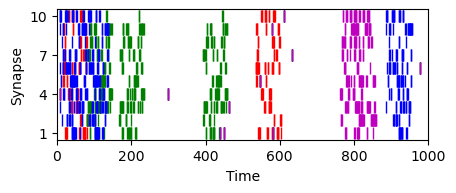

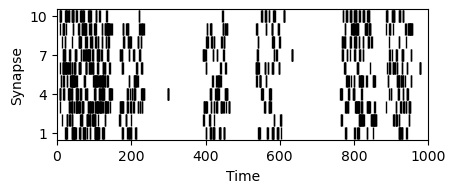

In [37]:
for suff in ['', '_k']:
    fig, ax = plt.subplots(1, 1, figsize=(env_fig1.opt.fig_width, env_fig1.opt.fig_width/2.5), subplotpars=subplotpars)
    for i_PG in range(env_fig1.opt.N_PGs):
        b_ = torch.zeros_like(b)
        b_[0, i_PG, :] = b[0, i_PG, :]
        a_ = env_fig1.draw_a(b_, PG)
        ax.eventplot([np.where(a_[0, i, :] == 1.)[0] for i in range(0, env_fig1.opt.N_pre)], 
                      colors=colors[i_PG] if suff=='' else 'k', 
                      lineoffsets=1, linelengths=0.9, linewidths=1);
    ax.set_ylabel('Synapse')
    ax.set_xlabel('Time')
    ax.set_xlim(0, env_fig1.opt.N_time)
    ax.set_ylim(-.5, env_fig1.opt.N_pre-.5)
    ax.set_yticks(np.arange(0, env_fig1.opt.N_pre, 3))
    ax.set_yticklabels(np.arange(0, env_fig1.opt.N_pre, 3)+1)
    #if not figpath is  None: fig.savefig(figpath + '/figure_1a' + suff + '.pdf')
    plt.show()

/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_75096/4230626902.py:118: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(y=i*np.ones((self.opt.N_PG_time,)),


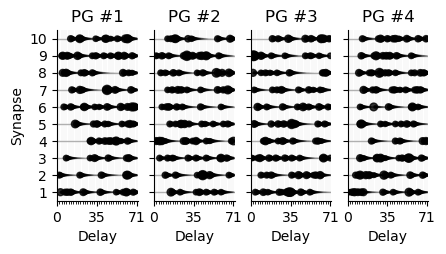

In [38]:
fig, axs = env_fig1.plot_PG(PG, aspect=15)
#if not figpath is  None: fig.savefig(figpath + '/figure_1c.pdf')
plt.show()

/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_75096/4230626902.py:118: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(y=i*np.ones((self.opt.N_PG_time,)),


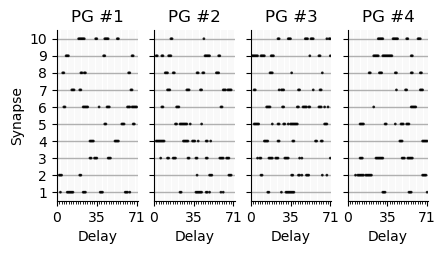

In [39]:
logit_p_A = torch.logit(torch.tensor(opt.p_A));
rp_PG = torch.sigmoid(logit_p_A + PG) > torch.rand(opt.N_pre, opt.N_PGs, opt.N_PG_time)
fig, axs = env_fig1.plot_PG(rp_PG, aspect=15);

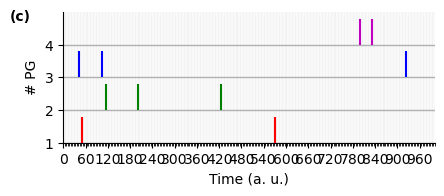

In [40]:
fig, ax = plt.subplots(1, 1, figsize=figsize, subplotpars=subplotpars)
colors = ['r', 'g' , 'b' , 'm']

for i in range(0, env_fig1.opt.N_PGs):
    ax.eventplot([np.where(b[0, i, :] == 1.)[0]], colors=colors[i], lineoffsets=1.*i+.4, linelengths=0.8);

ax.set_ylabel('# PG')
ax.set_xlabel('Time (a. u.)')
ax.set_xlim(0, env_fig1.opt.N_time)
ax.set_ylim(0, env_fig1.opt.N_PGs)

ax.set_yticks(np.arange(0, env_fig1.opt.N_PGs))
ax.set_yticklabels(np.arange(0, env_fig1.opt.N_PGs)+1)
for side in ['top', 'right']: ax.spines[side].set_visible(False)
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(4))
ax.set_xticks(np.arange(0, env_fig1.opt.N_time+1, 60))
ax.set_xticklabels(np.arange(0, env_fig1.opt.N_time+1, 60))
ax.grid(True, axis='y', linestyle='-', lw=1)
ax.grid(True, axis='x', which='both', linestyle='-', lw=.1)

fig.text(0.03, 0.95,'(c)', horizontalalignment='center', verticalalignment='center', weight='bold')

if not figpath is  None: fig.savefig(figpath + '/figure_1c.pdf') # TODO use printfig

TODO: montrer des PGs générant des vagues, du bruit de Poisson, des one-spike per neuron, ...

## scanning parameters

In [41]:
%mkdir -p data_cache

In [42]:
opt = init(datetag)
opt.datetag

'2022-07-12'

In [43]:
%ls data_cache/{opt.datetag}_scan_*.json

zsh:1: no matches found: data_cache/2022-07-12_scan_*.json


In [44]:
new_env = ABCD(opt)

In [45]:
scan_dicts= {'N_PGs' : [8, 13, 21, 34, 55, 89, 144, 233, 377, 610], #, 987, 1364, 2351],
             'N_PG_time' : [1, 3, 7, 15, 31, 63, 127, 255, 511],
             'N_pre' : [8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1364, 2351],
            }

label_dicts= {'N_PGs' : 'number of PGs',
             'N_PG_time' : 'duration of PGs',
             'N_pre' : 'number of presynaptic inputs',
            }
import os
import time
import pandas as pd
import numpy as np

N_cv = 10
seed = np.random.randint(1000)
verb = False

for key in scan_dicts:
    filename = f'data_cache/{opt.datetag}_scan_{key}.json'
    print(f'{filename=}')
    if os.path.isfile(filename):
        df_scan = pd.read_json(filename)
    else:
        measure_columns = [key, 'accuracy', 'TP', 'TN', 'time']
        df_scan = pd.DataFrame([], columns=measure_columns)
        i_loc = 0
        for i_value, value in enumerate(scan_dicts[key]):
            if verb: print('i_value', i_value + 1, ' /', len(scan_dicts[key]), end='\t')

            for i_cv in  range(N_cv):
                # tic
                since = time.time()
                # make a new model
                new_env = ABCD(opt)
                print(key, value)
                new_env.d[key] = value
                new_env.init()
                # draw a new set of PGs
                PG = new_env.set_PG(seed=seed+i_loc)
                # test it
                accuracy, TP, TN = new_env.test_model(PG, PG, seed=seed+i_loc+1)
                # toc
                elapsed_time = time.time() - since
                df_scan.loc[i_loc] = {key:value, 'accuracy':accuracy.item(), 'TP':TP.item(), 'TN':TN.item(), 'time':elapsed_time}
                i_loc += 1

                if verb: print(f" - One pass completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

        df_scan.to_json(filename)
    print(df_scan)

filename='data_cache/2022-07-12_scan_N_PGs.json'
N_PGs 8
N_PGs 8
N_PGs 8
N_PGs 8
N_PGs 8
N_PGs 8
N_PGs 8
N_PGs 8
N_PGs 8
N_PGs 8
N_PGs 13
N_PGs 13
N_PGs 13
N_PGs 13
N_PGs 13
N_PGs 13
N_PGs 13
N_PGs 13
N_PGs 13
N_PGs 13
N_PGs 21
N_PGs 21
N_PGs 21
N_PGs 21
N_PGs 21
N_PGs 21
N_PGs 21
N_PGs 21
N_PGs 21
N_PGs 21
N_PGs 34
N_PGs 34
N_PGs 34
N_PGs 34
N_PGs 34
N_PGs 34
N_PGs 34
N_PGs 34
N_PGs 34
N_PGs 34
N_PGs 55
N_PGs 55
N_PGs 55
N_PGs 55
N_PGs 55
N_PGs 55
N_PGs 55
N_PGs 55
N_PGs 55
N_PGs 55
N_PGs 89
N_PGs 89
N_PGs 89
N_PGs 89
N_PGs 89
N_PGs 89
N_PGs 89
N_PGs 89
N_PGs 89
N_PGs 89
N_PGs 144
N_PGs 144
N_PGs 144
N_PGs 144
N_PGs 144
N_PGs 144
N_PGs 144
N_PGs 144
N_PGs 144
N_PGs 144
N_PGs 233
N_PGs 233
N_PGs 233
N_PGs 233
N_PGs 233
N_PGs 233
N_PGs 233
N_PGs 233
N_PGs 233
N_PGs 233
N_PGs 377
N_PGs 377
N_PGs 377
N_PGs 377
N_PGs 377
N_PGs 377
N_PGs 377
N_PGs 377
N_PGs 377
N_PGs 377
N_PGs 610
N_PGs 610
N_PGs 610
N_PGs 610
N_PGs 610
N_PGs 610
N_PGs 610
N_PGs 610
N_PGs 610
N_PGs 610
    N_PGs  accuracy  

    N_PGs  accuracy        TP        TN       time
0       8  0.998775  0.363636  0.999387   0.115501
1       8  0.999325  0.653846  0.999662   0.108810
2       8  0.999350  0.606061  0.999675   0.106036
3       8  0.999200  0.522388  0.999600   0.104032
4       8  0.999275  0.641975  0.999637   0.105625
..    ...       ...       ...       ...        ...
95    610  0.999105  0.554286  0.999552  12.961477
96    610  0.999095  0.545065  0.999547  12.946258
97    610  0.999105  0.552515  0.999552  12.610565
98    610  0.999075  0.550923  0.999537  12.661943
99    610  0.999089  0.548775  0.999544  12.728037

[100 rows x 5 columns]


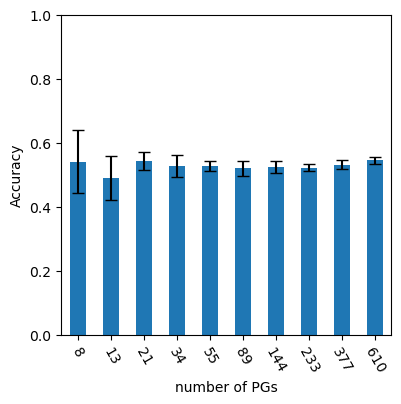

    N_PG_time  accuracy        TP        TN        time
0           1  0.999006  0.000000  1.000000    0.251158
1           1  0.998996  0.000000  1.000000    0.239027
2           1  0.998971  0.000000  1.000000    0.204722
3           1  0.998990  0.000000  1.000000    0.224892
4           1  0.999003  0.000000  1.000000    0.240436
..        ...       ...       ...       ...         ...
85        511  0.999441  0.725648  0.999720  133.463999
86        511  0.999436  0.718218  0.999718  131.025743
87        511  0.999475  0.734450  0.999737  132.776138
88        511  0.999444  0.722921  0.999722  139.405343
89        511  0.999448  0.727420  0.999724  133.840580

[90 rows x 5 columns]


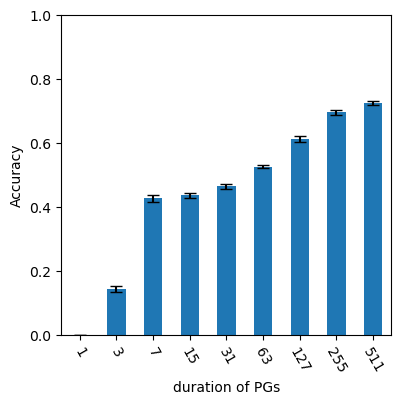

     N_pre  accuracy        TP        TN         time
0        8  0.998079  0.029319  0.999038    21.894303
1        8  0.998080  0.036848  0.999039    22.199943
2        8  0.998017  0.021996  0.999008    22.200350
3        8  0.998093  0.028233  0.999045    21.704748
4        8  0.998066  0.034844  0.999032    21.887447
..     ...       ...       ...       ...          ...
125   2351  0.999639  0.824270  0.999819  3326.997143
126   2351  0.999640  0.819408  0.999820  3338.249581
127   2351  0.999640  0.821822  0.999820  3328.526765
128   2351  0.999635  0.819142  0.999817  3333.206197
129   2351  0.999653  0.822375  0.999826  3319.068696

[130 rows x 5 columns]


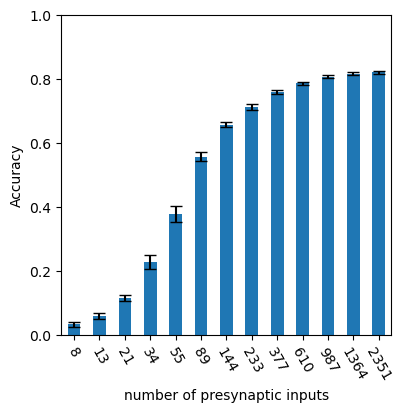

In [46]:
fig_width = 4
import matplotlib
#subplotpars = matplotlib.figure.SubplotParams(left=0., right=1., bottom=0., top=1., wspace=0., hspace=0.,)
subplotpars = matplotlib.figure.SubplotParams(left=0.15, right=.975, bottom=0.175, top=.975)

import matplotlib.pyplot as plt
for key in scan_dicts:
    filename = f'data_cache/{datetag}_scan_{key}.json'
    df_scan = pd.read_json(filename)
    print(df_scan)
    #for acc in ['TP', 'TN']
    #ax = df_scan.plot.scatter(x=key, y=['TP'], alpha=.1)
    #ax = df_scan.boxplot(column=key)
    # https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html?highlight=errorbar#visualization-errorbars
    gp_scan = df_scan[[key, 'TP']].groupby([key])
    means = gp_scan.mean()
    errors = gp_scan.std()
    fig, ax = plt.subplots(figsize=(fig_width, fig_width), subplotpars=subplotpars)
    means.plot.bar(yerr=errors, ax=ax, capsize=4, rot=-60, legend=False)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel(label_dicts[key])
    #ax.set_xscale('log')
    ax.set_ylim(0, 1)
    #fig = ax.get_figure()
    #if not figpath is  None: fig.savefig(figpath + '/figure_' + key + '.pdf')
    plt.show()

# Online clustering

## testing inference with wrong PGs 

In [47]:
env = ABCD(opt)

In [48]:
accuracy, TP, TN = env.test_model(PG=env.set_PG(seed=42), PG_true=env.set_PG(seed=42))
print(f'accuracy={accuracy.item()*100:.2f}%, TP={TP.item()*100:.2f}%, TN={TN.item()*100:.2f}%')

accuracy=99.94%, TP=72.08%, TN=99.97%


In [49]:
accuracy, TP, TN = env.test_model(PG=env.set_PG(seed=51), PG_true=env.set_PG(seed=42))
print(f'accuracy={accuracy.item()*100:.2f}%, TP={TP.item()*100:.2f}%, TN={TN.item()*100:.2f}%')

accuracy=99.80%, TP=0.10%, TN=99.90%


## learning 

In [50]:
PG_true = env.set_PG(seed=42)
import torch

class Net(torch.nn.Module):
    def __init__(self, N_pre, N_PGs, N_PG_time):
        super(Net, self).__init__()
        self.N_pre, self.N_PGs, self.N_PG_time = N_pre, N_PGs, N_PG_time
        #self.PG = torch.nn.Parameter(PG)
        #self.PG.requires_grad = True
        #self.b_threshold = torch.nn.Parameter(42. * torch.ones(1))
        #self.slope = torch.nn.Parameter(4.2 * torch.ones(1))
        # self.b_threshold.requires_grad = True
        # self.slope.requires_grad = True
        # https://pytorch.org/docs/master/generated/torch.nn.ConvTranspose1d.html#torch.nn.ConvTranspose1d
        self.convT = torch.nn.ConvTranspose1d(self.N_pre, self.N_PGs, self.N_PG_time, padding=self.N_PG_time//2)

    def forward(self, a):
        #N_trials, N_pre, N_time = a.shape
        # infer 
        #b_hat = torch.conv_transpose1d(a*1., self.PG, padding=self.N_PG_time//2)
        # decision: surrogate non-linearity
        #b_hat_bin = (b_hat-self.b_threshold)/self.slope
        b_hat = self.convT(a*1.)
        return b_hat

def learn_model(env, PG, PG_true, N_trials=32, N_learnsteps=10000, N_time=1000, N_time_blur=200, 
                lmbda=.001, lr=0.01, seed=31, **kwargs):
    torch.manual_seed(seed)
    N_pre, N_PGs, N_PG_time = PG.shape
    K_heat = torch.eye(N_PGs).unsqueeze(2) * torch.Tensor([.25, .5, .25]).unsqueeze(0).unsqueeze(0)

    criterion = torch.nn.BCEWithLogitsLoss()
    criterion_reg = torch.nn.BCELoss()

    model = Net(N_pre, N_PGs, N_PG_time)
    #optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for i_step in range(N_learnsteps):
        # draw causes (PGs) - hidden!
        b_true = env.get_b(seed=seed+i_step)
        # generate the corresponding raster plot - what is observed!
        a = env.draw_a(b_true, PG_true, seed=seed+i_step+1)
        # learn
        optimizer.zero_grad()

        if True: # supervised learning
            b_hat = 1. * b_true
        else:
            b_hat = model(a)

        # TODO : rajouter une incertitude sur le temps par une convolution
        time_blur = (N_time_blur*(N_learnsteps-i_step))//N_learnsteps
        # print(time_blur)
        for _ in range(time_blur):
            b_hat =  torch.conv1d(b_hat*1., K_heat, padding=1)

        a_hat = env.model_a(b_hat, model.convT.weight)
        #a_hat = model_a(b_true, model.convT.weight)
        # TODO : add homeostasis with a regularization on the firing rate of b_hat which we know should be uniform
        loss = criterion(a_hat, a*1.)
        #loss += lmbda * criterion_reg(torch.sigmoid(b_hat).mean(axis=(0, 2)), p_B*torch.ones(N_PGs))
        #loss += lmbda * criterion_reg(b_hat_bin.mean(axis=(0, 2)), p_B*torch.ones(N_PGs))
        loss.backward()
        optimizer.step()

        b_threshold = torch.quantile(b_hat.ravel()[:10000000], 1-env.opt.p_B)
        b_hat_bin = (b_hat > b_threshold) * 1.

        if i_step % 100 == 0:
            print(f'Train Epoch [{i_step:06d}/{N_learnsteps:06d}]\tLoss: {loss.item():.6f}\tAccuracy: {torch.mean((b_hat_bin == b_true)*1.):.6f}\tTP: {torch.mean(b_hat_bin[b_true==1]*1.):.6f}')
    return model

In [51]:
PG_start = env.set_PG(seed=51)
N_pre, N_PGs, N_PG_time = PG_start.shape
model = Net(N_pre, N_PGs, N_PG_time)

In [52]:
model = Net(N_pre, N_PGs, N_PG_time)

In [53]:
model.convT.weight.shape

torch.Size([256, 610, 511])

In [54]:
model = learn_model(env, PG_start, PG_true)

Train Epoch [000000/010000]	Loss: 0.694008	Accuracy: 0.998476	TP: 0.102154
Train Epoch [000100/010000]	Loss: 0.693109	Accuracy: 0.998514	TP: 0.099069
Train Epoch [000200/010000]	Loss: 0.693085	Accuracy: 0.998485	TP: 0.105083
Train Epoch [000300/010000]	Loss: 0.693040	Accuracy: 0.998598	TP: 0.092850
Train Epoch [000400/010000]	Loss: 0.693037	Accuracy: 0.998556	TP: 0.094438
Train Epoch [000500/010000]	Loss: 0.693018	Accuracy: 0.998531	TP: 0.097525
Train Epoch [000600/010000]	Loss: 0.692977	Accuracy: 0.998557	TP: 0.093956
Train Epoch [000700/010000]	Loss: 0.692924	Accuracy: 0.998575	TP: 0.093054
Train Epoch [000800/010000]	Loss: 0.692930	Accuracy: 0.998585	TP: 0.097126
Train Epoch [000900/010000]	Loss: 0.692910	Accuracy: 0.998505	TP: 0.101473
Train Epoch [001000/010000]	Loss: 0.692867	Accuracy: 0.998577	TP: 0.098017
Train Epoch [001100/010000]	Loss: 0.692920	Accuracy: 0.998545	TP: 0.105393
Train Epoch [001200/010000]	Loss: 0.692897	Accuracy: 0.998611	TP: 0.093375
Train Epoch [001300/01000

In [ ]:
model.convT.weight

Parameter containing:
tensor([[[-4.9964, -4.5866, -4.2623,  ..., -4.2846, -4.6159, -5.0276],
         [-5.0370, -4.6365, -4.2930,  ..., -4.2645, -4.5660, -4.9605],
         [-5.0293, -4.6424, -4.3022,  ..., -4.3069, -4.6389, -5.0564],
         ...,
         [-4.9976, -4.6204, -4.2847,  ..., -4.2426, -4.5744, -4.9871],
         [-5.0284, -4.6294, -4.2709,  ..., -4.2919, -4.6233, -5.0541],
         [-5.0289, -4.6200, -4.2876,  ..., -4.3187, -4.6578, -5.0585]],

        [[-4.9804, -4.5912, -4.2535,  ..., -4.3054, -4.6312, -5.0369],
         [-5.0285, -4.6325, -4.2946,  ..., -4.2592, -4.5668, -4.9612],
         [-5.0515, -4.6213, -4.3029,  ..., -4.3163, -4.6353, -5.0464],
         ...,
         [-5.0303, -4.6052, -4.2674,  ..., -4.2682, -4.5695, -4.9735],
         [-5.0181, -4.6246, -4.2962,  ..., -4.2932, -4.6269, -5.0516],
         [-5.0240, -4.6194, -4.2714,  ..., -4.3113, -4.6428, -5.0751]],

        [[-4.9723, -4.6032, -4.2560,  ..., -4.2905, -4.6203, -5.0518],
         [-5.0394, -4.6

In [ ]:
model.convT.bias

Parameter containing:
tensor([-2.7175e-03,  1.1056e-02,  1.2775e-02, -1.1402e-02,  1.1729e-03,
         1.1681e-02,  2.9413e-03, -9.8370e-03,  1.6625e-02, -9.3394e-03,
        -2.3713e-03,  1.4687e-02,  4.4529e-03,  1.1766e-02, -1.8675e-05,
        -1.5919e-02,  1.5160e-02,  2.2616e-03,  3.7805e-03,  7.2297e-03,
        -1.8387e-02,  2.8573e-03, -8.8098e-03, -1.4592e-03,  4.4312e-03,
        -7.2244e-03, -9.9020e-03,  1.1529e-02, -2.6339e-03,  2.0221e-03,
        -1.2580e-02, -1.7135e-02, -7.7069e-03,  1.8427e-02, -1.3614e-02],
       requires_grad=True)

# Annex